# Schools in Greenville, SC, How are they similar? 

First do data preprocessing in the "School_data_preprocessing" notebook.


The data sources are:

2015-2016 graduation rates: https://www2.ed.gov/about/inits/ed/edfacts/data-files/index.html#acgr

2015-2016 school location, characteristics, staff, and lunch programs: https://nces.ed.gov/ccd/pubschuniv.asp

2015-2016 school achievement: https://www2.ed.gov/about/inits/ed/edfacts/data-files/index.html#acgr

2015-2016 suspenion rates: https://ocrdata.ed.gov/DataAnalysisTools/DataSetBuilder?Report=4
for this analysis, we only focused on the greenville district schools, but you could select other areas of interest.
    

In [3]:
import numpy as np
import pandas as pd
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#Import data that has already been cleaned
path='/home/natalie/Documents/SchoolAPI/CleanedData/'

all_data=pd.read_csv(path+'all_data.csv', parse_dates=True) #includes school membership, math and reading scores

grad_all_data=pd.read_csv(path+'grad_all_data.csv', parse_dates=True)#includes school membership, math and reading scores, but since graduation rates are limited to high schools, this data is high school specific 

suspensions_all_data=pd.read_csv(path+'suspensions_all_data.csv', parse_dates=True) #includes all of the school membership, math and reading scores, but since suspensions were for Greenville County only, this data is limited to Greenville.

suspensions_grad_greenville=pd.read_csv(path+'suspensions_grad_greenville.csv', parse_dates=True)#graduation high school rates, plus suspensions in Greenville only

## The "All_Cohort" variable is all students in that school, then they are broken down into racial groups.

MAM = American Indian/Alaska Native students

MAS = Asian/Pacific Islander

MHI = Hispanic/Latino

MBL = Black

MWH = White

MTR = Two or more races

CWD = disabilities

ECD = Economically disadvanted

LEP = Limited English Proficiency

In [4]:
##remove any negative values as we cannot have negative students, these must be placeholders for something

#grad_all_data.loc[grad_all_data.G01_n_students<0, 'G01_n_students']=0
for i in range(len(list(suspensions_all_data))):
    #print(suspensions_all_data.iloc[:,i])
    if suspensions_all_data.iloc[:,i].dtype.kind not in ['O', 'f']: #O is a python object
        suspensions_all_data.iloc[:,i] = suspensions_all_data.iloc[:,i].mask(suspensions_all_data.iloc[:,i] < 0)
    #replace NAs with 0
        suspensions_all_data.iloc[:,i] = suspensions_all_data.iloc[:,i].fillna(0)
        
#same thing for grad data

for i in range(len(list(grad_all_data))):
    if grad_all_data.iloc[:,i].dtype.kind not in ['O', 'f']: #O is a python object
        grad_all_data.iloc[:,i] = grad_all_data.iloc[:,i].mask(grad_all_data.iloc[:,i] < 0)
    #replace NAs with 0
        grad_all_data.iloc[:,i] = grad_all_data.iloc[:,i].fillna(0)
        

Double check that all missing values are correctly filled in or removed prior to clustering algorithims which cannot handle NAs

In [5]:
na_list=grad_all_data.isna().sum()
na_list/len(grad_all_data) # percentage
#Because many of these race groups are so small the PS identifier was used, and then converted to NA.

Unnamed: 0             0.0
FIPST                  0.0
NCESSCH                0.0
LCITY                  0.0
LZIP                   0.0
G1OFFERED              0.0
G8OFFERED              0.0
G12OFFERED             0.0
NOGRADES               0.0
type_school            0.0
SCH_NAME_n_students    0.0
G01_n_students         0.0
G08_n_students         0.0
G12_n_students         0.0
TOTAL_n_students       0.0
AM_n_students          0.0
AMALM_n_students       0.0
AMALF_n_students       0.0
AS_n_students          0.0
ASALM_n_students       0.0
ASALF_n_students       0.0
HI_n_students          0.0
HIALM_n_students       0.0
HIALF_n_students       0.0
BL_n_students          0.0
BLALM_n_students       0.0
BLALF_n_students       0.0
WH_n_students          0.0
WHALM_n_students       0.0
WHALF_n_students       0.0
                      ... 
M_RLA00PCTPROF         0.0
MBL_RLAHSNUMVALID      0.0
MBL_RLAHSPCTPROF       0.0
MWH_RLAHSNUMVALID      0.0
MWH_RLAHSPCTPROF       0.0
STNAM_y                0.0
L

In [6]:
grad_all_data.head()

,Unnamed: 0,FIPST,NCESSCH,LCITY,LZIP,G1OFFERED,G8OFFERED,G12OFFERED,NOGRADES,type_school,...,ALL_RATE,MAM_RATE,MAS_RATE,MBL_RATE,MHI_RATE,MTR_RATE,MWH_RATE,CWD_RATE,ECD_RATE,LEP_RATE
0,0,1,10000500871,Albertville,35950,0,0,1,0,high_school,...,92.0,55.506429,67.515429,50.000000,95.000000,58.618379,90.0,60.0,80.0,50.000000
1,1,1,10000600872,Albertville,35951,0,1,1,0,high_school,...,95.0,55.506429,67.515429,66.321668,80.000000,58.618379,90.0,50.0,90.0,56.932155
2,2,1,10000601585,Guntersville,35976,0,0,1,0,high_school,...,85.0,55.506429,67.515429,66.321668,65.982353,58.618379,85.0,50.0,80.0,56.932155
3,3,1,10000600883,Grant,35747,0,0,1,0,high_school,...,80.0,55.506429,67.515429,66.321668,65.982353,58.618379,80.0,21.0,60.0,56.932155
4,4,1,10000600878,Douglas,35964,0,0,1,0,high_school,...,85.0,55.506429,67.515429,66.321668,90.000000,58.618379,85.0,50.0,85.0,56.932155


(array([ 277.,  572.,  419.,  462.,  114., 1932.,  909., 2581., 5649.,
        8752.]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <a list of 10 Patch objects>)

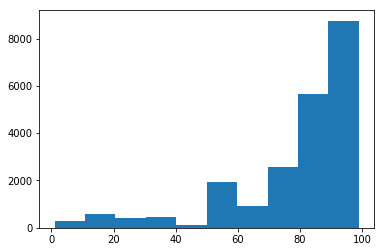

In [7]:
plt.hist(grad_all_data['ALL_RATE']) #most schools have above 80% graduation, but there is some negative skewing down towards lower rates.

Let's see how school suspensions correlate with graduation rates.
Plot the percentage of total students graduating vs the total number of suspensions for that group

### Math competence vs. suspensions for all students

Text(0,0.5,'percentage of all students proficient in math')

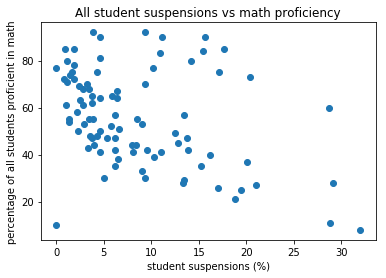

In [8]:
plt.scatter(suspensions_all_data['TOT_OSS_rate'],  suspensions_all_data['ALL_MTH00PCTPROF'])
plt.title('All student suspensions vs math proficiency')
plt.xlabel('student suspensions (%)')
plt.ylabel('percentage of all students proficient in math')

This has a trend we expect, as the number of suspensions increases the % of students proficient in math tends to decrease.
Let's see if there is a statistically relavant trend here:

In [9]:
#first create simple linear regression only using the type of race as a predictor
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('TOT_OSS_rate ~ ALL_MTH00PCTPROF', suspensions_all_data).fit()

print(model.summary())  

                            OLS Regression Results                            
Dep. Variable:           TOT_OSS_rate   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     15.25
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           0.000184
Time:                        13:37:12   Log-Likelihood:                -297.12
No. Observations:                  90   AIC:                             598.2
Df Residuals:                      88   BIC:                             603.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           16.0165      2.058  

This shows that math and suspension rates are inversely related. This OLS is analagous to a correlation coefficient, 
$$b_1=r  \frac{S_y}{S_x}$$

let's double check these results:

In [10]:
from scipy.stats.stats import pearsonr
#pearsonr(x, y)

pearsonr(suspensions_all_data['TOT_OSS_rate'] ,suspensions_all_data['ALL_MTH00PCTPROF'])

(-0.384349178247539, 0.0001840057968117242)

The first value is the correlation coefficient, -0.38, and the 2nd value is the p-value indicating that this is a significant negative correlation. Thus, the suspension rate and math proficiency are negatively correlated, meaning as 1 increases the other decreases.


## Let's compare suspension rate by race. 
When there is a very small group of students, the data is removed to protect privacy. Thus, there are many instances where the rates are shown as "0". Therefore, for this analysis we will remove these "0" entries.


In [11]:
susp_list=['TOT_OSS_rate', 'BLA_OSS_rate', 'WHI_OSS_rate']
suspensions_all_data_zerorm=suspensions_all_data
for i in susp_list:
    suspensions_all_data_zerorm=suspensions_all_data_zerorm[suspensions_all_data_zerorm[i] !=0] #removes all entries with a zero


In [12]:
#suspensions_trans1=[]
tot_oss=pd.DataFrame(columns=['OSS_rate','type', 'MTH'])
tot_oss['OSS_rate']=suspensions_all_data_zerorm['TOT_OSS_rate']
tot_oss['MTH']=suspensions_all_data_zerorm['ALL_MTH00PCTPROF']
tot_oss['type']='Total'
tot_oss=tot_oss.iloc[:-1] #unclear why it adds a 'total' to the bottom in the rate column, but remove this last value

In [13]:
BLA_oss=pd.DataFrame(columns=['OSS_rate','type'])
BLA_oss['OSS_rate']=suspensions_all_data_zerorm['BLA_OSS_rate']
BLA_oss['MTH']=suspensions_all_data_zerorm['MBL_MTH00PCTPROF']
BLA_oss['type']='BLA'

WH_oss=pd.DataFrame(columns=['OSS_rate','type'])
WH_oss['OSS_rate']=suspensions_all_data_zerorm['WHI_OSS_rate']
WH_oss['MTH']=suspensions_all_data_zerorm['MWH_MTH00PCTPROF']
WH_oss['type']='WHI'

oss_race_rate=pd.concat([tot_oss, BLA_oss, WH_oss])
oss_race_rate['OSS_rate']=oss_race_rate['OSS_rate'].astype(str).astype(float)
oss_race_rate.head()

,OSS_rate,type,MTH
0,13.48,Total,57
2,3.31,Total,43
4,3.45,Total,68
5,4.61,Total,81
6,8.38,Total,44


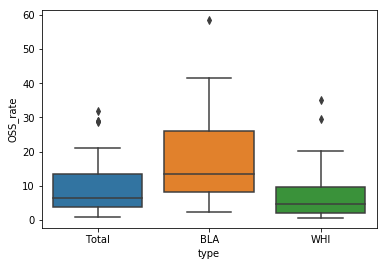

In [14]:
import seaborn as sns
# Make boxplot for one group only

sns.boxplot( y=oss_race_rate['OSS_rate'], x=oss_race_rate['type'])

It appears the suspension rate of black students is higher than white students, let's check the statstical significane.

In [15]:
#ANOVA to compare the three groups of suspension rates

#first create simple linear regression only using the type of race as a predictor
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('OSS_rate ~ type', oss_race_rate).fit()

print(model.summary())  

                            OLS Regression Results                            
Dep. Variable:               OSS_rate   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     35.73
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           2.32e-14
Time:                        13:37:12   Log-Likelihood:                -893.32
No. Observations:                 251   AIC:                             1793.
Df Residuals:                     248   BIC:                             1803.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.1490      0.933     18.380

These results suggest that race is a significant predictor of suspension rate.

Let's see if Math proficiency rates also differ by race:

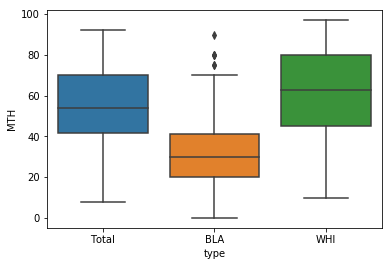

In [16]:
sns.boxplot( y=oss_race_rate['MTH'], x=oss_race_rate['type'])

Judging from the plots, it looks like math rates vary by race, let's check the stats:

In [17]:
#ANOVA table
modelM = ols('MTH ~ type', oss_race_rate).fit()
aov_tableM = sm.stats.anova_lm(modelM, typ=2)
aov_tableM

,sum_sq,df,F,PR(>F)
type,32649.342569,2.0,41.040088,4.010493e-16
Residual,98647.900459,248.0,NaN,NaN


### Let's revisit suspension rate vs math proficiency, and use race as a 2nd predictor

Text(29.3668,0.5,'percentage of students proficient in math')

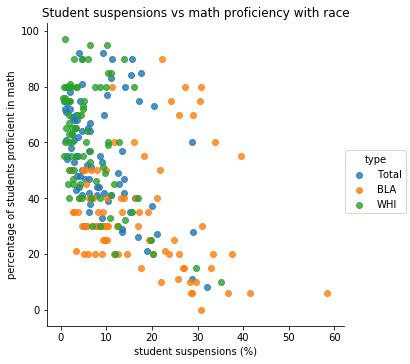

In [18]:
sns.lmplot( x='OSS_rate', y='MTH', data=oss_race_rate, fit_reg=False, hue='type')
plt.title('Student suspensions vs math proficiency with race')
plt.xlabel('student suspensions (%)')
plt.ylabel('percentage of students proficient in math')

This plot is telling us a few things:
    
    1. White kids tend to get suspended less, and generally have higher proficiency rates in Math
    2. Black kids tend to get suspended more and have lower proficiency rates in Math
    3. There is an outlier group, where black students are still suspended at higher rates (around 30%), but are still highly proficient in math (around 80%)
    
Let's see the statistical model results:

In [19]:
modelM2 = ols('MTH ~ OSS_rate+type', oss_race_rate).fit()
aov_tableM2 = sm.stats.anova_lm(modelM2, typ=2)
modelM2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MTH   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     38.08
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           2.90e-20
Time:                        13:37:13   Log-Likelihood:                -1094.0
No. Observations:                 251   AIC:                             2196.
Df Residuals:                     247   BIC:                             2210.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        46.1987      3.197     14.451      0.000      39.902      52.496
type[T.Total]    14.9500      3.166      4.721      0.000       8.713      21.187
type[T.WHI]      19.0950      3.308      5.772      0.000      12.580      25.610
OSS_rate         -0.6995      0.142     -4.941      0.000      -0.978      -0.421
==============================================================================
Omnibus:                       18.532   Durbin-Watson:                   1.204
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.943
Skew:                           0.706   Prob(JB):                     2.83e-05
Kurtosis:                       3.078   Cond. No.                         60.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
aov_tableM2

,sum_sq,df,F,PR(>F)
type,13149.761855,2.0,18.090021,4.659479e-08
OSS_rate,8874.893976,1.0,24.418240,1.430948e-06
Residual,89773.006483,247.0,NaN,NaN


Model results:
    1. both math proficiency and race are signifiant predictors of suspension rates
    2. The R2 of this model is slightly better than the originial model with only math proficiency as the independent variable

Let's see if we can see what makes the schools with highly proficient math scores for black students unique

In [21]:
pd.set_option('display.max_columns', 500)
suspensions_all_data_zerorm[suspensions_all_data_zerorm['MBL_MTH00PCTPROF']>75]

,Unnamed: 0,FIPST,NCESSCH,LCITY,LZIP,G1OFFERED,G8OFFERED,G12OFFERED,NOGRADES,type_school,SCH_NAME_n_students,G01_n_students,G08_n_students,G12_n_students,TOTAL_n_students,AM_n_students,AMALM_n_students,AMALF_n_students,AS_n_students,ASALM_n_students,ASALF_n_students,HI_n_students,HIALM_n_students,HIALF_n_students,BL_n_students,BLALM_n_students,BLALF_n_students,WH_n_students,WHALM_n_students,WHALF_n_students,HP_n_students,HPALM_n_students,HPALF_n_students,TR_n_students,TRALM_n_students,TRALF_n_students,FTE,STNAM_x,LEANM_x,ALL_RLA00NUMVALID,ALL_RLA00PCTPROF,F_RLA00NUMVALID,F_RLA00PCTPROF,M_RLA00NUMVALID,M_RLA00PCTPROF,MBL_RLAHSNUMVALID,MBL_RLAHSPCTPROF,MWH_RLAHSNUMVALID,MWH_RLAHSPCTPROF,STNAM_y,LEANM_y,ALL_MTH00NUMVALID,ALL_MTH00PCTPROF,MWH_MTH00PCTPROF,MBL_MTH00PCTPROF,F_MTH00NUMVALID,F_MTH00PCTPROF,M_MTH00NUMVALID,M_MTH00PCTPROF,MBL_MTHHSNUMVALID,MBL_MTHHSPCTPROF,MWH_MTHHSNUMVALID,MWH_MTHHSPCTPROF,TOT_n_susp,TOT_OSS_rate,BLA_OSS_rate,WHI_OSS_rate,AME_OSS_times_white,ASI_OSS_times_white,HI_PAC_OSS_times_white,BLA_OSS_times_white,HIS_OSS_times_white,TWO_OSS_times_white,TOT_n_enrollment
29,29,45,450231000571,Greer,29650,0,0,1,0,high_school,Riverside High,0.0,0.0,367.0,1667,2,2,0,113,55,58,153,83,70,164,86,78,1177,599,578,0,0,0,58,29,29,87.1,SOUTH CAROLINA,Greenville 01,349,90,167,90,182,85,37,60,236,95,SOUTH CAROLINA,Greenville 01,316,92,90,80,157,90,159,90,48,80,199,90,63,3.92,11.18,2.82,0.00,0.63,0.00,3.96,1.74,2.84,1674
32,32,45,450231000566,Greenville,29609,0,0,1,0,high_school,Wade Hampton High,0.0,0.0,381.0,1724,6,5,1,66,30,36,210,112,98,324,168,156,1049,511,538,9,5,4,60,34,26,90.1,SOUTH CAROLINA,Greenville 01,299,84,133,85,166,80,69,70,147,90,SOUTH CAROLINA,Greenville 01,348,90,95,80,167,90,181,85,74,80,180,95,259,15.68,30.79,10.07,0.00,0.64,3.97,3.06,2.14,1.50,1724
35,35,45,450231000563,Taylors,29687,0,0,1,0,high_school,Eastside High,0.0,0.0,328.0,1470,3,2,1,39,13,26,162,92,70,211,113,98,1004,503,501,0,0,0,51,25,26,79.0,SOUTH CAROLINA,Greenville 01,271,84,124,90,147,75,44,70,173,85,SOUTH CAROLINA,Greenville 01,272,92,90,90,132,90,140,90,51,90,167,90,132,9.30,22.27,6.04,0.00,0.00,0.00,3.69,1.99,2.70,1470
39,39,45,450231000560,Greenville,29617,0,0,1,0,high_school,Berea High,0.0,0.0,219.0,1025,5,3,2,8,5,3,326,183,143,314,157,157,335,168,167,1,1,0,36,19,17,68.5,SOUTH CAROLINA,Greenville 01,237,68,115,60,122,70,69,70,63,75,SOUTH CAROLINA,Greenville 01,262,85,90,80,123,85,139,80,73,80,68,90,178,17.61,27.24,13.94,2.05,0.00,0.00,1.95,0.74,2.61,1028


From observation, it appears these outlier schools:
    1. have simmilarily high reading proficiency rates for all students (black and white)
    2. are all high schools
    3. have simmilar sizes, all over 1,000 students although Berea high is the smallest

Let's see what some of the schools with low math proficiency look like:

In [22]:
suspensions_all_data_zerorm[suspensions_all_data_zerorm['MBL_MTH00PCTPROF']<40].head(7)

,Unnamed: 0,FIPST,NCESSCH,LCITY,LZIP,G1OFFERED,G8OFFERED,G12OFFERED,NOGRADES,type_school,SCH_NAME_n_students,G01_n_students,G08_n_students,G12_n_students,TOTAL_n_students,AM_n_students,AMALM_n_students,AMALF_n_students,AS_n_students,ASALM_n_students,ASALF_n_students,HI_n_students,HIALM_n_students,HIALF_n_students,BL_n_students,BLALM_n_students,BLALF_n_students,WH_n_students,WHALM_n_students,WHALF_n_students,HP_n_students,HPALM_n_students,HPALF_n_students,TR_n_students,TRALM_n_students,TRALF_n_students,FTE,STNAM_x,LEANM_x,ALL_RLA00NUMVALID,ALL_RLA00PCTPROF,F_RLA00NUMVALID,F_RLA00PCTPROF,M_RLA00NUMVALID,M_RLA00PCTPROF,MBL_RLAHSNUMVALID,MBL_RLAHSPCTPROF,MWH_RLAHSNUMVALID,MWH_RLAHSPCTPROF,STNAM_y,LEANM_y,ALL_MTH00NUMVALID,ALL_MTH00PCTPROF,MWH_MTH00PCTPROF,MBL_MTH00PCTPROF,F_MTH00NUMVALID,F_MTH00PCTPROF,M_MTH00NUMVALID,M_MTH00PCTPROF,MBL_MTHHSNUMVALID,MBL_MTHHSPCTPROF,MWH_MTHHSNUMVALID,MWH_MTHHSPCTPROF,TOT_n_susp,TOT_OSS_rate,BLA_OSS_rate,WHI_OSS_rate,AME_OSS_times_white,ASI_OSS_times_white,HI_PAC_OSS_times_white,BLA_OSS_times_white,HIS_OSS_times_white,TWO_OSS_times_white,TOT_n_enrollment
0,0,45,450231001633,Greenville,29607,0,0,0,0,unknown,Dr. Phinnize J. Fisher Middle,0.0,0.0,0.0,661,1,0,1,26,14,12,37,21,16,207,104,103,370,225,145,1,1,0,19,13,6,38.5,SOUTH CAROLINA,Greenville 01,654,59,281,65,373,54,0,0,0,0,SOUTH CAROLINA,Greenville 01,656,57,73,25,281,60,375,54,0,0,0,0,84,13.48,24.88,4.76,0.00,1.50,0.00,5.23,4.80,8.85,663
2,2,45,450231001524,Simpsonville,29680,0,1,0,0,middle,Ralph Chandler Middle,0.0,239.0,0.0,694,0,0,0,3,0,3,48,21,27,69,32,37,540,262,278,0,0,0,34,22,12,38.0,SOUTH CAROLINA,Greenville 01,699,48,361,59,338,37,0,0,0,0,SOUTH CAROLINA,Greenville 01,700,43,47,20,361,46,339,39,0,0,0,0,22,3.31,6.06,2.70,0.00,0.00,0.00,2.24,1.69,2.31,695
5,5,45,450231001466,Greenville,29607,1,1,0,0,elementary,Sterling School,54.0,72.0,0.0,835,3,1,2,58,21,37,20,11,9,300,152,148,417,217,200,0,0,0,37,18,19,46.5,SOUTH CAROLINA,Greenville 01,625,79,315,81,310,76,0,0,0,0,SOUTH CAROLINA,Greenville 01,625,81,97,30,315,82,310,80,0,0,0,0,38,4.61,9.30,0.98,0.00,3.52,0.00,9.49,10.74,5.52,835
6,6,45,450231001393,Greer,29651,0,1,0,0,middle,Blue Ridge Middle,0.0,317.0,0.0,912,1,1,0,6,4,2,55,30,25,37,23,14,796,407,389,0,0,0,17,11,6,55.0,SOUTH CAROLINA,Greenville 01,911,49,439,56,472,43,0,0,0,0,SOUTH CAROLINA,Greenville 01,910,44,46,11,439,46,471,42,0,0,0,0,75,8.38,25.71,7.69,0.00,0.00,0.00,3.34,1.00,1.37,916
8,8,45,450231001337,Piedmont,29673,0,1,0,0,middle,Woodmont Middle,0.0,210.0,0.0,632,0,0,0,1,1,0,47,20,27,209,96,113,337,157,180,1,1,0,37,20,17,38.5,SOUTH CAROLINA,Greenville 01,620,33,332,41,288,20,0,0,0,0,SOUTH CAROLINA,Greenville 01,622,25,32,10,333,26,289,20,0,0,0,0,121,19.48,28.43,13.99,0.00,0.00,0.00,2.03,1.33,1.91,633
9,9,45,450231001334,Travelers Rest,29690,1,0,0,0,elementary,Gateway Elementary,135.0,0.0,0.0,742,4,2,2,5,1,4,40,24,16,96,50,46,569,303,266,0,0,0,28,15,13,39.0,SOUTH CAROLINA,Greenville 01,330,44,159,50,171,35,0,0,0,0,SOUTH CAROLINA,Greenville 01,331,58,65,30,159,60,172,50,0,0,0,0,16,2.19,8.16,1.05,0.00,0.00,0.00,7.77,6.57,0.00,745
10,10,45,450231001254,Greenville,29611,0,1,0,0,middle,Tanglewood Middle,0.0,199.0,0.0,640,4,1,3,1,1,0,230,133,97,275,126,149,108,66,42,0,0,0,22,15,7,43.0,SOUTH CAROLINA,Greenville 01,625,17,293,20,332,12,0,0,0,0,SOUTH CAROLINA,Greenville 01,625,11,15,6,293,10,332,11,0,0,0,0,183,28.82,36.63,29.63,0.31,0.00,3.37,1.24,0.63,1.42,645


These schools are all Middle schools and elementary, other than that I cannot see a trend.

## Try clustering of schools to see if there is a way to group like schools together

Our dataset with math and reading, demographics and suspenion rates has only 84 entries, since this data is only for Greenville, SC. Thus, it is not the largest dataset for clustering, but we will give it a shot!

In [23]:
variable_list=list(suspensions_all_data_zerorm)

#for PCA or kmeans you need all numeric data, we can drop the categorical data, or 1-hot encode it

remove_list=[]
for i in variable_list:
    if suspensions_all_data_zerorm[i].dtype.kind not in ['i', 'f']:
        remove_list.append(i)

cluster_data=suspensions_all_data_zerorm.drop(remove_list, axis=1)        

### Start with Principal Component Analysis (PCA) to visuzlize data and see if there are any clusters

for PCA or kmeans you need all numeric data, we can drop the categorical data, or 1-hot encode it.


PCA takes all of the data variables for each datapoint, and trys to create n axis (usually 2-3) that summarizes all of that variability into a meaningful way. Example, if we start with 10 variables, we could condense this down into 2 variables and then plot the data on these new 2 variable axes (like an x-y axis plot).


In [24]:
suspensions_all_data_zerorm.head()

,Unnamed: 0,FIPST,NCESSCH,LCITY,LZIP,G1OFFERED,G8OFFERED,G12OFFERED,NOGRADES,type_school,SCH_NAME_n_students,G01_n_students,G08_n_students,G12_n_students,TOTAL_n_students,AM_n_students,AMALM_n_students,AMALF_n_students,AS_n_students,ASALM_n_students,ASALF_n_students,HI_n_students,HIALM_n_students,HIALF_n_students,BL_n_students,BLALM_n_students,BLALF_n_students,WH_n_students,WHALM_n_students,WHALF_n_students,HP_n_students,HPALM_n_students,HPALF_n_students,TR_n_students,TRALM_n_students,TRALF_n_students,FTE,STNAM_x,LEANM_x,ALL_RLA00NUMVALID,ALL_RLA00PCTPROF,F_RLA00NUMVALID,F_RLA00PCTPROF,M_RLA00NUMVALID,M_RLA00PCTPROF,MBL_RLAHSNUMVALID,MBL_RLAHSPCTPROF,MWH_RLAHSNUMVALID,MWH_RLAHSPCTPROF,STNAM_y,LEANM_y,ALL_MTH00NUMVALID,ALL_MTH00PCTPROF,MWH_MTH00PCTPROF,MBL_MTH00PCTPROF,F_MTH00NUMVALID,F_MTH00PCTPROF,M_MTH00NUMVALID,M_MTH00PCTPROF,MBL_MTHHSNUMVALID,MBL_MTHHSPCTPROF,MWH_MTHHSNUMVALID,MWH_MTHHSPCTPROF,TOT_n_susp,TOT_OSS_rate,BLA_OSS_rate,WHI_OSS_rate,AME_OSS_times_white,ASI_OSS_times_white,HI_PAC_OSS_times_white,BLA_OSS_times_white,HIS_OSS_times_white,TWO_OSS_times_white,TOT_n_enrollment
0,0,45,450231001633,Greenville,29607,0,0,0,0,unknown,Dr. Phinnize J. Fisher Middle,0.0,0.0,0.0,661,1,0,1,26,14,12,37,21,16,207,104,103,370,225,145,1,1,0,19,13,6,38.5,SOUTH CAROLINA,Greenville 01,654,59,281,65,373,54,0,0,0,0,SOUTH CAROLINA,Greenville 01,656,57,73,25,281,60,375,54,0,0,0,0,84,13.48,24.88,4.76,0.00,1.50,0.0,5.23,4.80,8.85,663
2,2,45,450231001524,Simpsonville,29680,0,1,0,0,middle,Ralph Chandler Middle,0.0,239.0,0.0,694,0,0,0,3,0,3,48,21,27,69,32,37,540,262,278,0,0,0,34,22,12,38.0,SOUTH CAROLINA,Greenville 01,699,48,361,59,338,37,0,0,0,0,SOUTH CAROLINA,Greenville 01,700,43,47,20,361,46,339,39,0,0,0,0,22,3.31,6.06,2.70,0.00,0.00,0.0,2.24,1.69,2.31,695
4,4,45,450231001517,Simpsonville,29681,1,0,0,0,elementary,Rudolph Gordon Elementary,139.0,0.0,0.0,792,4,3,1,24,12,12,53,30,23,70,31,39,616,316,300,1,1,0,24,17,7,44.8,SOUTH CAROLINA,Greenville 01,407,64,183,65,224,60,0,0,0,0,SOUTH CAROLINA,Greenville 01,408,68,67,60,183,65,225,65,0,0,0,0,27,3.45,11.76,1.82,27.47,0.00,0.0,6.46,4.48,3.92,797
5,5,45,450231001466,Greenville,29607,1,1,0,0,elementary,Sterling School,54.0,72.0,0.0,835,3,1,2,58,21,37,20,11,9,300,152,148,417,217,200,0,0,0,37,18,19,46.5,SOUTH CAROLINA,Greenville 01,625,79,315,81,310,76,0,0,0,0,SOUTH CAROLINA,Greenville 01,625,81,97,30,315,82,310,80,0,0,0,0,38,4.61,9.30,0.98,0.00,3.52,0.0,9.49,10.74,5.52,835
6,6,45,450231001393,Greer,29651,0,1,0,0,middle,Blue Ridge Middle,0.0,317.0,0.0,912,1,1,0,6,4,2,55,30,25,37,23,14,796,407,389,0,0,0,17,11,6,55.0,SOUTH CAROLINA,Greenville 01,911,49,439,56,472,43,0,0,0,0,SOUTH CAROLINA,Greenville 01,910,44,46,11,439,46,471,42,0,0,0,0,75,8.38,25.71,7.69,0.00,0.00,0.0,3.34,1.00,1.37,916


In [25]:
#remove unnecessary variables
suspensions_all_data_zerorm=suspensions_all_data_zerorm.drop(['Unnamed: 0', 'FIPST', 'SCH_NAME_n_students', 'STNAM_y', 'LEANM_y'], axis=1)

#1-hot encode the STNAM_x, LEANM_x, type_school, LCITY, PCA cannot handle non-numeric data

In [26]:
one_hot=pd.get_dummies(suspensions_all_data_zerorm[['STNAM_x', 'LEANM_x', 'type_school', 'LCITY']])
one_hot.head()

,STNAM_x_SOUTH CAROLINA,LEANM_x_Greenville 01,type_school_elementary,type_school_high_school,type_school_middle,type_school_unknown,LCITY_Fountain Inn,LCITY_Greenville,LCITY_Greer,LCITY_Marietta,LCITY_Mauldin,LCITY_Pelzer,LCITY_Piedmont,LCITY_Simpsonville,LCITY_Taylors,LCITY_Travelers Rest
0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
6,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [27]:
suspensions_one_hot=suspensions_all_data_zerorm.join(one_hot)

suspensions_one_hot=suspensions_one_hot.drop(['STNAM_x', 'LEANM_x', 'type_school', 'LCITY'], axis=1)

In [28]:
suspensions_one_hot.head()

,NCESSCH,LZIP,G1OFFERED,G8OFFERED,G12OFFERED,NOGRADES,G01_n_students,G08_n_students,G12_n_students,TOTAL_n_students,AM_n_students,AMALM_n_students,AMALF_n_students,AS_n_students,ASALM_n_students,ASALF_n_students,HI_n_students,HIALM_n_students,HIALF_n_students,BL_n_students,BLALM_n_students,BLALF_n_students,WH_n_students,WHALM_n_students,WHALF_n_students,HP_n_students,HPALM_n_students,HPALF_n_students,TR_n_students,TRALM_n_students,TRALF_n_students,FTE,ALL_RLA00NUMVALID,ALL_RLA00PCTPROF,F_RLA00NUMVALID,F_RLA00PCTPROF,M_RLA00NUMVALID,M_RLA00PCTPROF,MBL_RLAHSNUMVALID,MBL_RLAHSPCTPROF,MWH_RLAHSNUMVALID,MWH_RLAHSPCTPROF,ALL_MTH00NUMVALID,ALL_MTH00PCTPROF,MWH_MTH00PCTPROF,MBL_MTH00PCTPROF,F_MTH00NUMVALID,F_MTH00PCTPROF,M_MTH00NUMVALID,M_MTH00PCTPROF,MBL_MTHHSNUMVALID,MBL_MTHHSPCTPROF,MWH_MTHHSNUMVALID,MWH_MTHHSPCTPROF,TOT_n_susp,TOT_OSS_rate,BLA_OSS_rate,WHI_OSS_rate,AME_OSS_times_white,ASI_OSS_times_white,HI_PAC_OSS_times_white,BLA_OSS_times_white,HIS_OSS_times_white,TWO_OSS_times_white,TOT_n_enrollment,STNAM_x_SOUTH CAROLINA,LEANM_x_Greenville 01,type_school_elementary,type_school_high_school,type_school_middle,type_school_unknown,LCITY_Fountain Inn,LCITY_Greenville,LCITY_Greer,LCITY_Marietta,LCITY_Mauldin,LCITY_Pelzer,LCITY_Piedmont,LCITY_Simpsonville,LCITY_Taylors,LCITY_Travelers Rest
0,450231001633,29607,0,0,0,0,0.0,0.0,0.0,661,1,0,1,26,14,12,37,21,16,207,104,103,370,225,145,1,1,0,19,13,6,38.5,654,59,281,65,373,54,0,0,0,0,656,57,73,25,281,60,375,54,0,0,0,0,84,13.48,24.88,4.76,0.00,1.50,0.0,5.23,4.80,8.85,663,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2,450231001524,29680,0,1,0,0,0.0,239.0,0.0,694,0,0,0,3,0,3,48,21,27,69,32,37,540,262,278,0,0,0,34,22,12,38.0,699,48,361,59,338,37,0,0,0,0,700,43,47,20,361,46,339,39,0,0,0,0,22,3.31,6.06,2.70,0.00,0.00,0.0,2.24,1.69,2.31,695,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,450231001517,29681,1,0,0,0,139.0,0.0,0.0,792,4,3,1,24,12,12,53,30,23,70,31,39,616,316,300,1,1,0,24,17,7,44.8,407,64,183,65,224,60,0,0,0,0,408,68,67,60,183,65,225,65,0,0,0,0,27,3.45,11.76,1.82,27.47,0.00,0.0,6.46,4.48,3.92,797,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5,450231001466,29607,1,1,0,0,54.0,72.0,0.0,835,3,1,2,58,21,37,20,11,9,300,152,148,417,217,200,0,0,0,37,18,19,46.5,625,79,315,81,310,76,0,0,0,0,625,81,97,30,315,82,310,80,0,0,0,0,38,4.61,9.30,0.98,0.00,3.52,0.0,9.49,10.74,5.52,835,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
6,450231001393,29651,0,1,0,0,0.0,317.0,0.0,912,1,1,0,6,4,2,55,30,25,37,23,14,796,407,389,0,0,0,17,11,6,55.0,911,49,439,56,472,43,0,0,0,0,910,44,46,11,439,46,471,42,0,0,0,0,75,8.38,25.71,7.69,0.00,0.00,0.0,3.34,1.00,1.37,916,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [29]:
# 1. Use StandardScaler to help you standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) 
from sklearn.preprocessing import StandardScaler

# Standardizing the features
suspensions_one_hot_std = StandardScaler().fit_transform(suspensions_one_hot)
suspensions_one_hot_std=pd.DataFrame(suspensions_one_hot_std)
suspensions_one_hot_std.columns=suspensions_one_hot.columns

In [30]:
suspensions_one_hot_std_array = StandardScaler().fit_transform(suspensions_one_hot)

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(suspensions_one_hot_std)

principalDf = pd.DataFrame(data = principalComponents
            , columns = ['principal component 1', 'principal component 2'])

In [32]:
principalDf.head()

,principal component 1,principal component 2
0,-1.449409,1.451190
1,-2.719033,2.905969
2,-0.827557,-2.785031
3,0.571731,-0.637015
4,-2.241960,4.847355


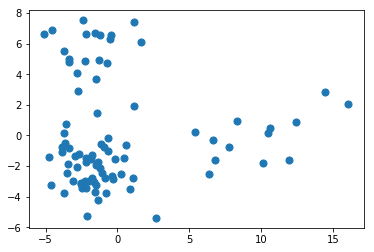

In [33]:
plt.scatter(principalDf['principal component 1'],principalDf['principal component 2'], s=50)

### With this visual look, there may be 3 distinct clusters, try Kmeans on PCA axes

In [34]:
from sklearn.cluster import KMeans
#do k-means clustering on 2 components created earlier
labels = KMeans(3, random_state=0).fit_predict(principalDf)
labels

array([0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0], dtype=int32)

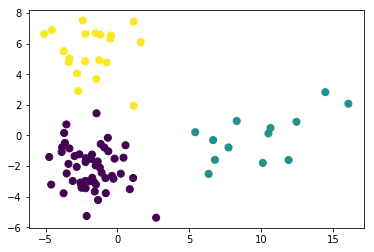

In [35]:
principalDf['kmeans']=labels #assign the labels to the principal coordinate dataset
plt.scatter(principalDf['principal component 1'],principalDf['principal component 2'], s=50, c=labels)

In [36]:

#add in these kmeans labels to the original dataset, and see how the groups we are interested in change with the clusters
suspensions_all_data_zerorm['kmeans_PCA']=labels

Let's see how the cluster classification compares across different math trends by race

In [37]:
suspensions_all_data_zerorm[['kmeans_PCA', 'ALL_MTH00PCTPROF', 'MBL_MTH00PCTPROF', 'BLA_OSS_rate']].groupby(['kmeans_PCA'], as_index=False).mean()

,kmeans_PCA,ALL_MTH00PCTPROF,MBL_MTH00PCTPROF,BLA_OSS_rate
0,0,55.529412,33.058824,10.984314
1,1,80.846154,69.230769,25.442308
2,2,35.750000,14.350000,27.478500


In [38]:
suspensions_all_data2=suspensions_all_data.merge(suspensions_all_data_zerorm[['NCESSCH', 'kmeans_PCA']], on='NCESSCH', how='inner')

In [39]:
suspensions_all_data_zerorm.head()

,NCESSCH,LCITY,LZIP,G1OFFERED,G8OFFERED,G12OFFERED,NOGRADES,type_school,G01_n_students,G08_n_students,G12_n_students,TOTAL_n_students,AM_n_students,AMALM_n_students,AMALF_n_students,AS_n_students,ASALM_n_students,ASALF_n_students,HI_n_students,HIALM_n_students,HIALF_n_students,BL_n_students,BLALM_n_students,BLALF_n_students,WH_n_students,WHALM_n_students,WHALF_n_students,HP_n_students,HPALM_n_students,HPALF_n_students,TR_n_students,TRALM_n_students,TRALF_n_students,FTE,STNAM_x,LEANM_x,ALL_RLA00NUMVALID,ALL_RLA00PCTPROF,F_RLA00NUMVALID,F_RLA00PCTPROF,M_RLA00NUMVALID,M_RLA00PCTPROF,MBL_RLAHSNUMVALID,MBL_RLAHSPCTPROF,MWH_RLAHSNUMVALID,MWH_RLAHSPCTPROF,ALL_MTH00NUMVALID,ALL_MTH00PCTPROF,MWH_MTH00PCTPROF,MBL_MTH00PCTPROF,F_MTH00NUMVALID,F_MTH00PCTPROF,M_MTH00NUMVALID,M_MTH00PCTPROF,MBL_MTHHSNUMVALID,MBL_MTHHSPCTPROF,MWH_MTHHSNUMVALID,MWH_MTHHSPCTPROF,TOT_n_susp,TOT_OSS_rate,BLA_OSS_rate,WHI_OSS_rate,AME_OSS_times_white,ASI_OSS_times_white,HI_PAC_OSS_times_white,BLA_OSS_times_white,HIS_OSS_times_white,TWO_OSS_times_white,TOT_n_enrollment,kmeans_PCA
0,450231001633,Greenville,29607,0,0,0,0,unknown,0.0,0.0,0.0,661,1,0,1,26,14,12,37,21,16,207,104,103,370,225,145,1,1,0,19,13,6,38.5,SOUTH CAROLINA,Greenville 01,654,59,281,65,373,54,0,0,0,0,656,57,73,25,281,60,375,54,0,0,0,0,84,13.48,24.88,4.76,0.00,1.50,0.0,5.23,4.80,8.85,663,0
2,450231001524,Simpsonville,29680,0,1,0,0,middle,0.0,239.0,0.0,694,0,0,0,3,0,3,48,21,27,69,32,37,540,262,278,0,0,0,34,22,12,38.0,SOUTH CAROLINA,Greenville 01,699,48,361,59,338,37,0,0,0,0,700,43,47,20,361,46,339,39,0,0,0,0,22,3.31,6.06,2.70,0.00,0.00,0.0,2.24,1.69,2.31,695,2
4,450231001517,Simpsonville,29681,1,0,0,0,elementary,139.0,0.0,0.0,792,4,3,1,24,12,12,53,30,23,70,31,39,616,316,300,1,1,0,24,17,7,44.8,SOUTH CAROLINA,Greenville 01,407,64,183,65,224,60,0,0,0,0,408,68,67,60,183,65,225,65,0,0,0,0,27,3.45,11.76,1.82,27.47,0.00,0.0,6.46,4.48,3.92,797,0
5,450231001466,Greenville,29607,1,1,0,0,elementary,54.0,72.0,0.0,835,3,1,2,58,21,37,20,11,9,300,152,148,417,217,200,0,0,0,37,18,19,46.5,SOUTH CAROLINA,Greenville 01,625,79,315,81,310,76,0,0,0,0,625,81,97,30,315,82,310,80,0,0,0,0,38,4.61,9.30,0.98,0.00,3.52,0.0,9.49,10.74,5.52,835,0
6,450231001393,Greer,29651,0,1,0,0,middle,0.0,317.0,0.0,912,1,1,0,6,4,2,55,30,25,37,23,14,796,407,389,0,0,0,17,11,6,55.0,SOUTH CAROLINA,Greenville 01,911,49,439,56,472,43,0,0,0,0,910,44,46,11,439,46,471,42,0,0,0,0,75,8.38,25.71,7.69,0.00,0.00,0.0,3.34,1.00,1.37,916,2


In [40]:
suspensions_all_data2.head(10)

,Unnamed: 0,FIPST,NCESSCH,LCITY,LZIP,G1OFFERED,G8OFFERED,G12OFFERED,NOGRADES,type_school,SCH_NAME_n_students,G01_n_students,G08_n_students,G12_n_students,TOTAL_n_students,AM_n_students,AMALM_n_students,AMALF_n_students,AS_n_students,ASALM_n_students,ASALF_n_students,HI_n_students,HIALM_n_students,HIALF_n_students,BL_n_students,BLALM_n_students,BLALF_n_students,WH_n_students,WHALM_n_students,WHALF_n_students,HP_n_students,HPALM_n_students,HPALF_n_students,TR_n_students,TRALM_n_students,TRALF_n_students,FTE,STNAM_x,LEANM_x,ALL_RLA00NUMVALID,ALL_RLA00PCTPROF,F_RLA00NUMVALID,F_RLA00PCTPROF,M_RLA00NUMVALID,M_RLA00PCTPROF,MBL_RLAHSNUMVALID,MBL_RLAHSPCTPROF,MWH_RLAHSNUMVALID,MWH_RLAHSPCTPROF,STNAM_y,LEANM_y,ALL_MTH00NUMVALID,ALL_MTH00PCTPROF,MWH_MTH00PCTPROF,MBL_MTH00PCTPROF,F_MTH00NUMVALID,F_MTH00PCTPROF,M_MTH00NUMVALID,M_MTH00PCTPROF,MBL_MTHHSNUMVALID,MBL_MTHHSPCTPROF,MWH_MTHHSNUMVALID,MWH_MTHHSPCTPROF,TOT_n_susp,TOT_OSS_rate,BLA_OSS_rate,WHI_OSS_rate,AME_OSS_times_white,ASI_OSS_times_white,HI_PAC_OSS_times_white,BLA_OSS_times_white,HIS_OSS_times_white,TWO_OSS_times_white,TOT_n_enrollment,kmeans_PCA
0,0,45,450231001633,Greenville,29607,0,0,0,0,unknown,Dr. Phinnize J. Fisher Middle,0.0,0.0,0.0,661,1,0,1,26,14,12,37,21,16,207,104,103,370,225,145,1,1,0,19,13,6,38.5,SOUTH CAROLINA,Greenville 01,654,59,281,65,373,54,0,0,0,0,SOUTH CAROLINA,Greenville 01,656,57,73,25,281,60,375,54,0,0,0,0,84,13.48,24.88,4.76,0.00,1.50,0.00,5.23,4.80,8.85,663,0
1,2,45,450231001524,Simpsonville,29680,0,1,0,0,middle,Ralph Chandler Middle,0.0,239.0,0.0,694,0,0,0,3,0,3,48,21,27,69,32,37,540,262,278,0,0,0,34,22,12,38.0,SOUTH CAROLINA,Greenville 01,699,48,361,59,338,37,0,0,0,0,SOUTH CAROLINA,Greenville 01,700,43,47,20,361,46,339,39,0,0,0,0,22,3.31,6.06,2.70,0.00,0.00,0.00,2.24,1.69,2.31,695,2
2,4,45,450231001517,Simpsonville,29681,1,0,0,0,elementary,Rudolph Gordon Elementary,139.0,0.0,0.0,792,4,3,1,24,12,12,53,30,23,70,31,39,616,316,300,1,1,0,24,17,7,44.8,SOUTH CAROLINA,Greenville 01,407,64,183,65,224,60,0,0,0,0,SOUTH CAROLINA,Greenville 01,408,68,67,60,183,65,225,65,0,0,0,0,27,3.45,11.76,1.82,27.47,0.00,0.00,6.46,4.48,3.92,797,0
3,5,45,450231001466,Greenville,29607,1,1,0,0,elementary,Sterling School,54.0,72.0,0.0,835,3,1,2,58,21,37,20,11,9,300,152,148,417,217,200,0,0,0,37,18,19,46.5,SOUTH CAROLINA,Greenville 01,625,79,315,81,310,76,0,0,0,0,SOUTH CAROLINA,Greenville 01,625,81,97,30,315,82,310,80,0,0,0,0,38,4.61,9.30,0.98,0.00,3.52,0.00,9.49,10.74,5.52,835,0
4,6,45,450231001393,Greer,29651,0,1,0,0,middle,Blue Ridge Middle,0.0,317.0,0.0,912,1,1,0,6,4,2,55,30,25,37,23,14,796,407,389,0,0,0,17,11,6,55.0,SOUTH CAROLINA,Greenville 01,911,49,439,56,472,43,0,0,0,0,SOUTH CAROLINA,Greenville 01,910,44,46,11,439,46,471,42,0,0,0,0,75,8.38,25.71,7.69,0.00,0.00,0.00,3.34,1.00,1.37,916,2
5,7,45,450231001365,Greer,29650,1,0,0,0,elementary,Buena Vista Elementary,170.0,0.0,0.0,854,3,2,1,76,45,31,62,36,26,74,37,37,599,302,297,0,0,0,40,20,20,45.8,SOUTH CAROLINA,Greenville 01,415,79,208,80,207,70,0,0,0,0,SOUTH CAROLINA,Greenville 01,418,78,80,40,208,75,210,80,0,0,0,0,16,1.91,13.16,0.67,0.00,0.00,0.00,19.64,6.09,0.00,852,0
6,8,45,450231001337,Piedmont,29673,0,1,0,0,middle,Woodmont Middle,0.0,210.0,0.0,632,0,0,0,1,1,0,47,20,27,209,96,113,337,157,180,1,1,0,37,20,17,38.5,SOUTH CAROLINA,Greenville 01,620,33,332,41,288,20,0,0,0,0,SOUTH CAROLINA,Greenville 01,622,25,32,10,333,26,289,20,0,0,0,0,121,19.48,28.43,13.99,0.00,0.00,0.00,2.03,1.33,1.91,633,2
7,9,45,450231001334,Travelers Rest,29690,1,0,0,0,elementary,Gateway Elementary,135.0,0.0,0.0,742,4,2,2,5,1,4,40,24,16,96,50,46,569,303,266,0,0,0,28,15,13,39.0,SOUTH CAROLINA,Greenville 01,330,44,159,50,171,35,0,0,0,0,SOUTH CAROLINA,Greenville 01,331,58,65,30,159,60,172,50,0,0,0,0,16,2.19,8.16,1.05,0.00,0.00,0.00,7.77,6.57,0.00,745,0
8,10,45,450231001254,Greenville,29611,0,1,0,0,middle,Tanglewood Middle,0.0,199.0,0.0,640,4,1,3,1,1,0,230,133,97,275,126,149,108,66,42,0,0,0,22,15,7,43.0,SOUTH CAROLINA,Greenville 01,625,17,293,20,332,12,0,0,0,0,SOUT

In [41]:
suspensions_all_data_zerorm.groupby('kmeans_PCA').mean()

,NCESSCH,LZIP,G1OFFERED,G8OFFERED,G12OFFERED,NOGRADES,G01_n_students,G08_n_students,G12_n_students,TOTAL_n_students,AM_n_students,AMALM_n_students,AMALF_n_students,AS_n_students,ASALM_n_students,ASALF_n_students,HI_n_students,HIALM_n_students,HIALF_n_students,BL_n_students,BLALM_n_students,BLALF_n_students,WH_n_students,WHALM_n_students,WHALF_n_students,HP_n_students,HPALM_n_students,HPALF_n_students,TR_n_students,TRALM_n_students,TRALF_n_students,FTE,ALL_RLA00NUMVALID,ALL_RLA00PCTPROF,F_RLA00NUMVALID,F_RLA00PCTPROF,M_RLA00NUMVALID,M_RLA00PCTPROF,MBL_RLAHSNUMVALID,MBL_RLAHSPCTPROF,MWH_RLAHSNUMVALID,MWH_RLAHSPCTPROF,ALL_MTH00NUMVALID,ALL_MTH00PCTPROF,MWH_MTH00PCTPROF,MBL_MTH00PCTPROF,F_MTH00NUMVALID,F_MTH00PCTPROF,M_MTH00NUMVALID,M_MTH00PCTPROF,MBL_MTHHSNUMVALID,MBL_MTHHSPCTPROF,MWH_MTHHSNUMVALID,MWH_MTHHSPCTPROF,TOT_n_susp,TOT_OSS_rate,BLA_OSS_rate,WHI_OSS_rate,AME_OSS_times_white,ASI_OSS_times_white,HI_PAC_OSS_times_white,BLA_OSS_times_white,HIS_OSS_times_white,TWO_OSS_times_white,TOT_n_enrollment
kmeans_PCA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.502310e+11,29642.176471,0.960784,0.019608,0.019608,0.0,116.843137,1.411765,1.745098,711.921569,2.549020,1.274510,1.274510,14.862745,7.333333,7.529412,114.549020,60.450980,54.098039,167.705882,86.607843,81.098039,380.098039,197.176471,182.921569,1.176471,0.647059,0.529412,30.980392,15.960784,15.019608,43.392157,349.921569,49.294118,169.431373,52.274510,180.490196,42.352941,0.235294,0.980392,0.764706,1.764706,351.529412,55.529412,61.921569,33.058824,170.058824,54.156863,181.470588,53.019608,0.254902,0.980392,0.666667,1.764706,33.450980,5.081373,10.984314,3.585294,1.107451,1.068627,0.433725,4.336667,1.423137,2.921569,714.333333
1,4.502310e+11,29644.923077,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,330.230769,1507.230769,2.461538,1.692308,0.769231,35.153846,16.384615,18.769231,174.230769,93.538462,80.692308,331.000000,170.153846,160.846154,915.384615,469.153846,446.230769,2.153846,1.153846,1.000000,46.846154,23.692308,23.153846,81.015385,306.615385,77.846154,141.538462,78.076923,165.076923,73.846154,77.230769,65.000000,167.230769,80.384615,301.230769,80.846154,83.461538,69.230769,145.230769,81.923077,156.000000,76.923077,80.461538,69.230769,158.769231,83.461538,194.923077,14.148462,25.442308,9.244615,0.898462,0.214615,1.606154,2.975385,1.476154,2.494615,1511.230769
2,4.502310e+11,29641.450000,0.050000,0.950000,0.100000,0.0,6.000000,257.900000,8.500000,841.000000,2.800000,1.650000,1.150000,17.000000,8.250000,8.750000,136.900000,71.150000,65.750000,214.950000,108.350000,106.600000,433.350000,224.450000,208.900000,1.400000,0.800000,0.600000,34.600000,19.250000,15.350000,51.325000,780.900000,41.200000,377.950000,46.500000,402.950000,35.550000,7.450000,4.250000,1.750000,2.500000,784.950000,35.750000,43.100000,14.350000,379.850000,36.550000,405.100000,34.300000,6.900000,4.500000,1.950000,1.000000,121.700000,15.513000,27.478500,11.986000,0.906500,0.816000,0.648500,2.712000,1.095000,2.465500,842.600000


This works well, we can see low performing schools with mth proficiency ratings at 35, and black mth proficiency at 14 are in cluster '2', while the high performing schools are in cluster '1'.

### Let's make sure I picked the right number of clusters, let's look at the elbow

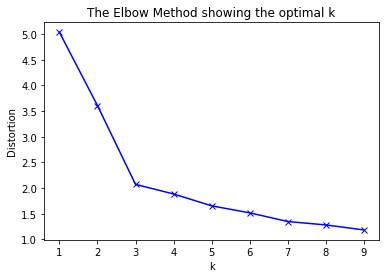

In [42]:
from scipy.spatial.distance import cdist

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(principalDf)
    kmeanModel.fit(principalDf)
    distortions.append(sum(np.min(cdist(principalDf, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / principalDf.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


Yep, I picked right! We only need 3 clusters

### What if we do k-means on standardized data, not the principal components?

In [43]:
labels_all = KMeans(3, random_state=0).fit_predict(suspensions_one_hot_std)

suspensions_all_data_zerorm['kmeans2']=labels_all

In [44]:
suspensions_all_data_zerorm[['kmeans2', 'ALL_MTH00PCTPROF', 'MBL_MTH00PCTPROF', 'BLA_OSS_rate']].groupby(['kmeans2'], as_index=False).mean()

,kmeans2,ALL_MTH00PCTPROF,MBL_MTH00PCTPROF,BLA_OSS_rate
0,0,80.846154,69.230769,25.442308
1,1,37.200000,14.600000,26.849500
2,2,54.960784,32.960784,11.230980


breakdown by math scores and black suspension rates is about the same as with PCA first.

## What are most important variables for clustering?

Let's use a Random forest model to see if we can see which features are important in breaking the data out by the assigned k-means group.

In [45]:
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
#X, y = make_classification(n_samples=1000,
#                           n_features=10,
#                           n_informative=3,
#                           n_redundant=0,
#                           n_repeated=0,
#                           n_classes=2,
#                           random_state=0,
#                           shuffle=False)

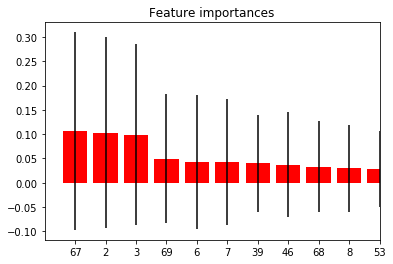

In [46]:
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=suspensions_one_hot_std.shape[0],
                              random_state=0)

forest.fit(suspensions_one_hot_std_array, labels_all)# X,Y X is array, 1 per row, Y is the assigned k-means
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(suspensions_one_hot_std_array.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(suspensions_one_hot_std_array.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(suspensions_one_hot_std_array.shape[1]), indices)
plt.xlim([-1, 10])
plt.show()

In [47]:
top10=indices[0:10]
top10

array([67,  2,  3, 69,  6,  7, 39, 46, 68,  8])

In [48]:
suspensions_one_hot_std.iloc[:,top10].head() #these are the most important variables in order

,type_school_elementary,G1OFFERED,G8OFFERED,type_school_middle,G01_n_students,G08_n_students,MBL_RLAHSPCTPROF,F_MTH00NUMVALID,type_school_high_school,G12_n_students
0,-1.183216,-1.212678,-0.559017,-0.522233,-1.123032,-0.522296,-0.475504,0.563420,-0.466252,-0.432132
1,-1.183216,-1.212678,1.788854,1.914854,-1.123032,1.482601,-0.475504,1.258643,-0.466252,-0.432132
2,0.845154,0.824621,-0.559017,-0.522233,1.033987,-0.522296,-0.475504,-0.288228,-0.466252,-0.432132
3,0.845154,0.824621,1.788854,-0.522233,-0.285053,0.081690,-0.475504,0.858890,-0.466252,-0.432132
4,-1.183216,-1.212678,1.788854,1.914854,-1.123032,2.136919,-0.475504,1.936486,-0.466252,-0.432132


Because these feautures were selected as the most important, it appears the type of school (elementary, middle) and how many students they have make the biggest impact. Next, Black high school students proficiency in Reading, and number of females in the entire school that were proficient in Math are the other important variables.

In [49]:
## Use logistic regression and see if we can predict if the school is a elementary or not

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

/home/natalie/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [50]:
suspensions_one_hot['type_school_elementary'].value_counts()
#the data is roughly equally divided

1    49
0    35
Name: type_school_elementary, dtype: int64

In [51]:
logreg = LogisticRegression()
X=suspensions_one_hot.loc[:, suspensions_one_hot.columns !='type_school_elementary'] #predictors are everything expect our target of school type
Y=suspensions_one_hot.loc[:, suspensions_one_hot.columns =='type_school_elementary']

#standardized data
Xstd=suspensions_one_hot_std.loc[:, suspensions_one_hot_std.columns !='type_school_elementary']

In [52]:
type(X)

pandas.core.frame.DataFrame

In [53]:
#need to get rid of some features, because logistic regression is unalbe to perform if too many features are simmilar
#recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.
#First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. 
#Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.
#we will select 12 features to keep
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 12)
rfe = rfe.fit(X, Y.values.ravel())
print(rfe.ranking_)

rfestd=rfe = rfe.fit(Xstd, Y.values.ravel())

[ 1  1 36 43 46 69  1  1  1  1 41 68 40 25 33 28 27 29 31  9 17 15  1  3
  6 52 55 58 42 37 50 22  1 49  5 35  1 30 13 16  7 12  1 20 19 32  4 24
  2 21 10 14  8 11  1 23 18 26 45 39 47 34 51 38  1 53 54 48 44 59 64 56
 60 65 63 62 67 61 57 66]


In [54]:
X=suspensions_one_hot.loc[:,rfe.support_]
Xstd=suspensions_one_hot_std.loc[:,rfestd.support_]
Xstd.head(2)

,G1OFFERED,G12OFFERED,G01_n_students,G08_n_students,ALL_RLA00NUMVALID,M_RLA00NUMVALID,MBL_RLAHSPCTPROF,MWH_RLAHSPCTPROF,MBL_MTHHSPCTPROF,TOT_n_susp,TOT_OSS_rate,type_school_high_school
0,-1.212678,-0.485071,-1.123032,-0.522296,0.894627,1.182562,-0.475504,-0.46013,-0.467068,0.061729,0.636711,-0.466252
1,-1.212678,-0.485071,-1.123032,1.482601,1.088021,0.890939,-0.475504,-0.46013,-0.467068,-0.779856,-0.798535,-0.466252


In [55]:
X.head(2)

,G1OFFERED,G12OFFERED,G01_n_students,G08_n_students,ALL_RLA00NUMVALID,M_RLA00NUMVALID,MBL_RLAHSPCTPROF,MWH_RLAHSPCTPROF,MBL_MTHHSPCTPROF,TOT_n_susp,TOT_OSS_rate,type_school_high_school
0,0,0,0.0,0.0,654,373,0,0,0,84,13.48,0
2,0,0,0.0,239.0,699,338,0,0,0,22,3.31,0


Of these important variables, let's drop some of the ones that have multicollinearity

In [56]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,18.086273,G1OFFERED
1,57.995794,G12OFFERED
2,22.000827,G01_n_students
3,18.675931,G08_n_students
4,359.455638,ALL_RLA00NUMVALID
5,310.582628,M_RLA00NUMVALID
6,67.697923,MBL_RLAHSPCTPROF
7,98.662172,MWH_RLAHSPCTPROF
8,43.306834,MBL_MTHHSPCTPROF
9,21.478150,TOT_n_susp


In [57]:
X=X.drop(['ALL_RLA00NUMVALID','M_RLA00NUMVALID', 'type_school_high_school', 'MWH_RLAHSPCTPROF', 'MBL_RLAHSPCTPROF', 'G1OFFERED' ,'G12OFFERED', 'MBL_MTHHSPCTPROF', 'G08_n_students', 'G01_n_students'], axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,6.546745,TOT_n_susp
1,6.546745,TOT_OSS_rate


In [58]:
#check VIF on standardized data
vifstd = pd.DataFrame()
vifstd["VIF Factor"] = [variance_inflation_factor(Xstd.values, i) for i in range(Xstd.shape[1])]
vifstd["features"] = Xstd.columns
vifstd

,VIF Factor,features
0,27.410775,G1OFFERED
1,48.273978,G12OFFERED
2,10.524555,G01_n_students
3,14.673188,G08_n_students
4,86.839229,ALL_RLA00NUMVALID
5,66.033355,M_RLA00NUMVALID
6,55.578891,MBL_RLAHSPCTPROF
7,88.586612,MWH_RLAHSPCTPROF
8,35.555191,MBL_MTHHSPCTPROF
9,13.437921,TOT_n_susp


In [59]:
vifstd

,VIF Factor,features
0,27.410775,G1OFFERED
1,48.273978,G12OFFERED
2,10.524555,G01_n_students
3,14.673188,G08_n_students
4,86.839229,ALL_RLA00NUMVALID
5,66.033355,M_RLA00NUMVALID
6,55.578891,MBL_RLAHSPCTPROF
7,88.586612,MWH_RLAHSPCTPROF
8,35.555191,MBL_MTHHSPCTPROF
9,13.437921,TOT_n_susp


In [60]:
Xstd=Xstd.drop(['ALL_RLA00NUMVALID','type_school_high_school', 'MWH_RLAHSPCTPROF', 'M_RLA00NUMVALID', 'G1OFFERED', 'G12OFFERED', 'G01_n_students', 'G08_n_students', 'MBL_MTHHSPCTPROF', 'MBL_RLAHSPCTPROF'], axis=1) #remove male/female designations b/c theyse sum up together

In [61]:
import statsmodels.api as sm
logit_model=sm.Logit(Y,X)
result_lr=logit_model.fit()
#print(result.summary2())

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


/home/natalie/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [62]:
Xstd.index=X.index

In [63]:
#standardized data
logit_modelstd=sm.Logit(Y,Xstd)
result_lrstd=logit_modelstd.fit(method='bfgs')

         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 90
         Gradient evaluations: 78


/home/natalie/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [64]:
result_lr.summary()

/home/natalie/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/natalie/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/natalie/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                             
==================================================================================
Dep. Variable:     type_school_elementary   No. Observations:                   84
Model:                              Logit   Df Residuals:                       82
Method:                               MLE   Df Model:                            1
Date:                    Tue, 23 Oct 2018   Pseudo R-squ.:                     inf
Time:                            13:37:16   Log-Likelihood:                   -inf
converged:                           True   LL-Null:                        0.0000
                                            LLR p-value:                     1.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
TOT_n_susp      -0.0398      0.015     -2.699      0.007      -0.069      -0.011
TOT_OSS_rate     0.2496      0.107      2.332      0.020       0.040       0.459
================================================================================
"""

In [65]:
result_lrstd.summary()

/home/natalie/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/natalie/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/natalie/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:3313: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                             
==================================================================================
Dep. Variable:     type_school_elementary   No. Observations:                   84
Model:                              Logit   Df Residuals:                       82
Method:                               MLE   Df Model:                            1
Date:                    Tue, 23 Oct 2018   Pseudo R-squ.:                     inf
Time:                            13:37:16   Log-Likelihood:                -58.224
converged:                          False   LL-Null:                        0.0000
                                            LLR p-value:                     1.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
TOT_n_susp            0      0.380          0      1.000      -0.745       0.745
TOT_OSS_rate          0      0.380          0      1.000      -0.745       0.745
================================================================================
"""

In [66]:
#logistic regression w/ sklearn instead of stats model

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_trainstd, X_teststd, y_trainstd, y_teststd = train_test_split(Xstd, Y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
log_model=logreg.fit(X_train, y_train)

log_model

/home/natalie/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [67]:
#Let's see what schools are predicted correctly
y_predLR = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.96


In [68]:
#Confusion matrix, let's examine our false positives (we erronouesly predict a school is classified as elementary),
#and our false negatives (we fail to classify a school as elementary when we should)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predLR)
print(confusion_matrix)

#[True neg, False positive]Predicted along x, actual on column going down
#[False negative, True positive]

#  [0 1]predicted
#0
#1

[[ 7  0]
 [ 1 18]]


In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predLR))

             precision    recall  f1-score   support

          0       0.88      1.00      0.93         7
          1       1.00      0.95      0.97        19

avg / total       0.97      0.96      0.96        26



Let's try a different train/test approach, using k-folds cross validation, where we split the data into 5 subsets, and each subset is used once as a test set and the other k-1 subsets are used as the training data

In [70]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)  


KFold(n_splits=5, random_state=None, shuffle=False)


In [71]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, X, Y, cv=5)
scores                        

/home/natalie/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/natalie/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/natalie/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/natalie/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

array([0.82352941, 0.94117647, 1.        , 1.        , 0.875     ])

We could take the average of these results, and compare it to a different model and see if the other model performs better or worse. On average, we can expect this model to perform well:

In [72]:
scores.mean()

0.9279411764705883

In [73]:
corr=suspensions_one_hot.corr()
corrhigh=corr

## Hierarchical Clustering

Data must be in matrix form with nxm (n=number of samples, m=number of features).

the linkage() function will use that method and metric to calculate the distances of the clusters (starting with your n individual samples (aka data points) as singleton clusters)) and in each iteration will merge the two clusters which have the smallest distance according the selected method and metric.

In [74]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(suspensions_one_hot, 'average') #linkdage used is average, this is the average distance between all the points in each cluster and the other cluster

In [75]:
#check the Cophenetic Correlation Coefficient of your clustering with help of the cophenet() function. This compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. 
#The closer the value is to 1, the better the clustering preserves the original distances, 

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.4371267590809473

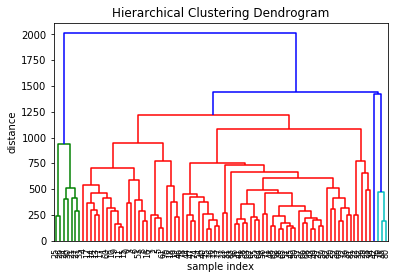

In [76]:
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

We can now pick what distance we want to be the 'cutoff' so we have that many 'clusters'. if we draw a horizontal line at distance (y-axis)=1250, this would create 3 clusters, which are already shown by green, red and blue.
We can pick this manually, or with some canned methods.

## Support Vector Machines
Use SVM to see if we can better classify the school type into elementary or not

In [77]:
from sklearn import svm
svm_model = svm.SVC(kernel='rbf') #gamma is
svm_model.fit(X_train, y_train)  

/home/natalie/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [78]:
svm_model.score(X_train, y_train)

0.9827586206896551

In [79]:
#SVM with 5-fold validation
scores = cross_val_score(svm_model, X, Y, cv=5)
scores                        

/home/natalie/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/natalie/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/natalie/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/natalie/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

array([0.88235294, 0.82352941, 0.58823529, 0.88235294, 0.875     ])

In [80]:
#get predictions from SVM
y_predSVM = svm_model.predict(X_test) 
#pring confusion matrix for SVM
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,y_predSVM)) 
#  1   0 #predicted
#1[    ]
#0[    ]
#actual
print(classification_report(y_test,y_predSVM))  

[[ 7  0]
 [ 9 10]]
             precision    recall  f1-score   support

          0       0.44      1.00      0.61         7
          1       1.00      0.53      0.69        19

avg / total       0.85      0.65      0.67        26



In [81]:
#this performed worse than logisitc regression. it appears the predictor variables are not helpful in determining if a school is elementary or not

## Regularization

use standardized data
suspensions_one_hot_std

Sklearn logistic regression uses regularization L2 (lasso) by default, let's see if L1 (Ridge) changes things

In [82]:
logreg_L1 = LogisticRegression(penalty='l1')

logreg_L1.fit(X_trainstd, y_trainstd)
logreg_L1.score(X_teststd, y_teststd) #Ridge regularization

/home/natalie/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0

In [83]:
logreg = LogisticRegression(penalty='l2')
logreg.fit(X_trainstd, y_trainstd)
logreg.score(X_teststd, y_teststd) #Lasso

/home/natalie/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9230769230769231

## linear regression, predict math proficiency


In [84]:
grad_all_data.head()

,Unnamed: 0,FIPST,NCESSCH,LCITY,LZIP,G1OFFERED,G8OFFERED,G12OFFERED,NOGRADES,type_school,SCH_NAME_n_students,G01_n_students,G08_n_students,G12_n_students,TOTAL_n_students,AM_n_students,AMALM_n_students,AMALF_n_students,AS_n_students,ASALM_n_students,ASALF_n_students,HI_n_students,HIALM_n_students,HIALF_n_students,BL_n_students,BLALM_n_students,BLALF_n_students,WH_n_students,WHALM_n_students,WHALF_n_students,HP_n_students,HPALM_n_students,HPALF_n_students,TR_n_students,TRALM_n_students,TRALF_n_students,FTE,STNAM_x,LEANM_x,ALL_RLA00NUMVALID,ALL_RLA00PCTPROF,F_RLA00NUMVALID,F_RLA00PCTPROF,M_RLA00NUMVALID,M_RLA00PCTPROF,MBL_RLAHSNUMVALID,MBL_RLAHSPCTPROF,MWH_RLAHSNUMVALID,MWH_RLAHSPCTPROF,STNAM_y,LEANM_y,ALL_MTH00NUMVALID,ALL_MTH00PCTPROF,MWH_MTH00PCTPROF,MBL_MTH00PCTPROF,F_MTH00NUMVALID,F_MTH00PCTPROF,M_MTH00NUMVALID,M_MTH00PCTPROF,MBL_MTHHSNUMVALID,MBL_MTHHSPCTPROF,MWH_MTHHSNUMVALID,MWH_MTHHSPCTPROF,ALL_COHORT,ALL_RATE,MAM_RATE,MAS_RATE,MBL_RATE,MHI_RATE,MTR_RATE,MWH_RATE,CWD_RATE,ECD_RATE,LEP_RATE
0,0,1,10000500871,Albertville,35950,0,0,1,0,high_school,Albertville High Sch,0.0,0.0,282.0,1290.0,2.0,0.0,2.0,6.0,6.0,0.0,470.0,250.0,220.0,36.0,18.0,18.0,762.0,360.0,402.0,2.0,0.0,2.0,12.0,6.0,6.0,67.28,ALABAMA,Albertville City,307,31,162,30,145,25,9,50,178,35,ALABAMA,Albertville City,307,15,20,50,161,15,146,10,9,50,177,20,296.0,92.0,55.506429,67.515429,50.000000,95.000000,58.618379,90.0,60.0,80.0,50.000000
1,1,1,10000600872,Albertville,35951,0,1,1,0,high_school,Asbury Sch,0.0,77.0,67.0,538.0,1.0,1.0,0.0,2.0,1.0,1.0,189.0,93.0,96.0,3.0,0.0,3.0,340.0,190.0,150.0,2.0,1.0,1.0,1.0,0.0,1.0,28.37,ALABAMA,Marshall County,297,27,139,35,158,15,0,0,46,20,ALABAMA,Marshall County,299,33,30,0,141,35,158,30,0,0,46,10,67.0,95.0,55.506429,67.515429,66.321668,80.000000,58.618379,90.0,50.0,90.0,56.932155
2,2,1,10000601585,Guntersville,35976,0,0,1,0,high_school,Brindlee Mt High Sch,0.0,0.0,82.0,358.0,1.0,1.0,0.0,3.0,2.0,1.0,17.0,10.0,7.0,6.0,4.0,2.0,330.0,167.0,163.0,0.0,0.0,0.0,1.0,1.0,0.0,19.80,ALABAMA,Marshall County,87,25,42,40,45,11,3,0,78,25,ALABAMA,Marshall County,87,6,6,0,42,11,45,10,3,0,78,6,94.0,85.0,55.506429,67.515429,66.321668,65.982353,58.618379,85.0,50.0,80.0,56.932155
3,3,1,10000600883,Grant,35747,0,0,1,0,high_school,Kate D Smith DAR High Sch,0.0,0.0,114.0,457.0,1.0,0.0,1.0,1.0,1.0,0.0,6.0,3.0,3.0,3.0,1.0,2.0,445.0,230.0,215.0,0.0,0.0,0.0,1.0,1.0,0.0,25.65,ALABAMA,Marshall County,116,55,61,60,55,50,1,0,112,55,ALABAMA,Marshall County,116,15,15,0,61,20,55,11,1,0,112,15,120.0,80.0,55.506429,67.515429,66.321668,65.982353,58.618379,80.0,21.0,60.0,56.932155
4,4,1,10000600878,Douglas,35964,0,0,1,0,high_school,Douglas High Sch,0.0,0.0,148.0,593.0,6.0,3.0,3.0,2.0,2.0,0.0,142.0,77.0,65.0,8.0,4.0,4.0,435.0,224.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0,31.09,ALABAMA,Marshall County,146,25,66,25,80,20,3,0,108,20,ALABAMA,Marshall County,148,6,6,0,66,6,82,6,3,0,108,6,153.0,85.0,55.506429,67.515429,66.321668,90.000000,58.618379,85.0,50.0,85.0,56.932155


In [85]:

mathX=grad_all_data[['TOTAL_n_students', 'FTE', 'ALL_RATE']]
mathY=grad_all_data['ALL_MTH00PCTPROF']

mathX_train, mathX_test, mathy_train, mathy_test = train_test_split(mathX, mathY, test_size=0.3, random_state=0)

In [86]:
grad_all_data.head()
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(mathX_train, mathy_train)
reg_test_score=reg.score(mathX_test, mathy_test)
reg_test_score

0.13691618418999907

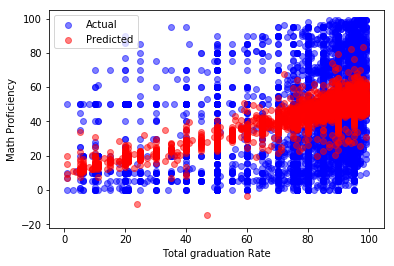

In [87]:
predMath=reg.predict(mathX_test)
import matplotlib.pyplot as plt

plt.scatter(mathX_test['ALL_RATE'], mathy_test, c="blue", alpha=0.5,
            label="Actual")
plt.scatter(mathX_test['ALL_RATE'], predMath, c="red", alpha=0.5,
            label="Predicted")
plt.xlabel("Total graduation Rate")
plt.ylabel("Math Proficiency")
plt.legend(loc='upper left')

In [88]:
#Regularize the linear model
# Get the MSE
lm_ridge = Ridge(alpha = 0.02)
lm_ridge.fit(mathX_train, mathy_train)
ridge_predictMath=lm_ridge.predict(mathX_test)
lm_ridge.score(mathX_test, mathy_test)

NameError: name 'Ridge' is not defined

In [ ]:
#this model is performing about the same as linear model, as to be expected no huge gains

In [ ]:
plt.scatter(mathX_test['ALL_RATE'], mathy_test, c="blue", alpha=0.5,
            label="Actual")
plt.scatter(mathX_test['ALL_RATE'], ridge_predictMath, c="red", alpha=0.5,
            label="Predicted")
plt.xlabel("Total graduation Rate")
plt.ylabel("Math Proficiency")
plt.legend(loc='upper left')
plt.title('Ridge Regression')

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

#Ridge regression
rr = Ridge(alpha=15) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
rr.fit(mathX_train, mathy_train)

In [ ]:
Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_test, y_test)
Ridge_test_score

In [ ]:
LR_test_score=logreg.score(X_test, y_test)
LR_test_score

## Lasso Regression